### 题目描述：

根据数据data.csv，预测下一个 tick 发生 order retreat 事件的概率。Order retreat 指一个或多个挂单，被交易员撤消（也就是data.csv里下一行Order Retreat值>0）。应使用至少15%的数据做样本外测试。

Order Book 相关信息可以在Rebuilding the limit order book sequential Bayesian inference on hidden states里找到。

### 注释：


Last Px，最近一笔成交的成交价

Volume，当个交易日日累计成交量

Turnover，当个交易日日累计成交额 = Volume * Average Trade Px

Bid Px，最优Bid价格

Bid Vol，最优Bid数量

Ask Px，最优Ask价格

Ask Vol，最优Ask数量

Bid Arrival，上个Tick到当个Tick的Bid Order 新增Volume总和

Bid Retreat，上个Tick到当个Tick的Bid Order 撤单Volume总和

Bid Taken，上个Tick到当个Tick的Bid Order 成交Volume总和

Ask Arrival，上个Tick到当个Tick的Ask Order 新增Volume总和

Ask Retreat，上个Tick到当个Tick的Ask Order 撤单Volume总和

Ask Taken，上个Tick到当个Tick的Ask Order 成交Volume总和


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
data = pd.read_csv('hf_data.csv')

In [18]:
data.head()

,Time,Last Px,Turnover,Volume,Bid Px,Bid Vol,Ask Px,Ask Vol,Bid Arrival,Ask Arrival,Bid Retreat,Ask Retreat,Bid Taken,Ask Taken
0,'20170524 07:02:58.200',17010,0,0,NaN,0,NaN,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,'20170524 09:29:00.200',16996,781816,46,16996.0,2,16997.0,3,32.878092,35.121908,0.0,0.0,22.878092,23.121908
2,'20170524 09:30:00.200',16994,917772,54,16991.0,1,16995.0,9,9.000000,16.000000,1.0,1.0,8.000000,0.000000
3,'20170524 09:30:00.700',16995,1121690,66,16988.0,1,16994.0,1,7.500000,8.500000,3.0,0.0,5.500000,6.500000
4,'20170524 09:30:01.200',16985,1240602,73,16984.0,1,16988.0,10,13.000000,21.000000,3.0,1.0,7.000000,0.000000


In [19]:
data.shape

(97191, 14)

## Data pre-processing 

In [20]:
data.isnull().any()

Time           False
Last Px        False
Turnover       False
Volume         False
Bid Px          True
Bid Vol        False
Ask Px          True
Ask Vol        False
Bid Arrival    False
Ask Arrival    False
Bid Retreat    False
Ask Retreat    False
Bid Taken      False
Ask Taken      False
dtype: bool

In [21]:
new_day_list = data[data['Bid Px'].isnull() == True].index.tolist() #找到新的一天开始时候的index
print(new_day_list)

[0, 19936, 40909, 59918, 78521]


In [22]:
new_day_list = data[data['Ask Px'].isnull() == True].index.tolist() #找到新的一天开始时候的index
print(new_day_list)

[0, 19936, 40909, 59918, 78521]


In [23]:
# 生成每行数据的label,第一行数据有缺失值，而有缺失值的数目不多可以丢弃,这里没有丢弃，只是为了预测下一行
y1 = pd.DataFrame(data['Bid Retreat'].loc[1:])
y1 = y1.reset_index(drop=True)  
y2 = pd.DataFrame(data['Ask Retreat'].loc[1:])
y2 = y2.reset_index(drop=True)  
data = data.drop([97190])
data = data.fillna(0.0)

In [24]:
data.isnull().any()# 检查空值

Time           False
Last Px        False
Turnover       False
Volume         False
Bid Px         False
Bid Vol        False
Ask Px         False
Ask Vol        False
Bid Arrival    False
Ask Arrival    False
Bid Retreat    False
Ask Retreat    False
Bid Taken      False
Ask Taken      False
dtype: bool

In [25]:
data

,Time,Last Px,Turnover,Volume,Bid Px,Bid Vol,Ask Px,Ask Vol,Bid Arrival,Ask Arrival,Bid Retreat,Ask Retreat,Bid Taken,Ask Taken
0,'20170524 07:02:58.200',17010,0,0,0.0,0,0.0,0,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000
1,'20170524 09:29:00.200',16996,781816,46,16996.0,2,16997.0,3,32.878092,35.121908,0.000000e+00,0.0,22.878092,23.121908
2,'20170524 09:30:00.200',16994,917772,54,16991.0,1,16995.0,9,9.000000,16.000000,1.000000e+00,1.0,8.000000,0.000000
3,'20170524 09:30:00.700',16995,1121690,66,16988.0,1,16994.0,1,7.500000,8.500000,3.000000e+00,0.0,5.500000,6.500000
4,'20170524 09:30:01.200',16985,1240602,73,16984.0,1,16988.0,10,13.000000,21.000000,3.000000e+00,1.0,7.000000,0.000000
5,'20170524 09:30:01.700',16984,1291560,76,16982.0,1,16984.0,2,1.500000,7.500000,0.000000e+00,2.0,1.500000,1.500000
6,'20170524 09:30:02.200',16982,1393466,82,16982.0,1,16983.0,3,4.000000,10.000000,1.000000e+00,3.0,0.000000,6.000000
7,'20170524 09:30:02.700',16981,1444410,85,16981.0,1,16983.0,3,8.000000,2.000000,1.000000e+00,2.0,3.000000,0.000000
8,'20170524 09:30:03.200',16984,1563287,92,16980.0,6,16984.0,1,2.000000,4.000000,0.000000e+00,3.0,2.000000,5.000000
9,'20170524 09:30:03.700',16981,1597248,94,16980.0,5,16981.0,5,2.750000,9.250000,0.000000e+00,0.0,1.750000,0.250000


In [26]:
#笨方法，耗时很长
'''
data['spread'] = 0
for i in range(data.shape[0]):
    data['spread'].iloc[i] = data['Ask Px'].iloc[i] - data['Bid Px'].iloc[i]
'''


"\ndata['spread'] = 0\nfor i in range(data.shape[0]):\n    data['spread'].iloc[i] = data['Ask Px'].iloc[i] - data['Bid Px'].iloc[i]\n"

In [27]:
class DataProcessing:
    '''
    用于生成新的feature
    '''
    # apply函数用于生成新的feature
    def spreads(self, a, b):     
        return a - b
    
    def Bid_Ask_spreads(self, NewData):
        NewData['Bid_Ask_spreads'] = NewData.apply(lambda x: DataProcessing().spreads(x['Ask Px'], x['Bid Px']), axis=1)
        return NewData
    
    def mid(self, a, b):     
        return (a + b)/2.0
    
    def mid_spreads(self, NewData):
        NewData['mid_spreads'] = NewData.apply(lambda x: DataProcessing().mid( x['Ask Px'], x['Bid Px']), axis=1)
        return NewData

    
    def Vol_difference(self, NewData):
        NewData['Vol_difference'] = NewData.apply(lambda x: DataProcessing().spreads( x['Ask Vol'], x['Bid Vol']), axis=1)
        return NewData

    
    def Arrival_difference(self,  NewData):
        NewData['Arrival_difference'] = NewData.apply(lambda x: DataProcessing().spreads( x['Ask Arrival'], x['Bid Arrival']), axis=1)
        return NewData

    
    def Taken_difference(self, NewData):
        NewData['Taken_difference'] = NewData.apply(lambda x: DataProcessing().spreads( x['Ask Taken'], x['Bid Taken']), axis=1)
        return NewData

    

In [28]:
data = DataProcessing().Bid_Ask_spreads(data)
data = DataProcessing().mid_spreads(data)
data = DataProcessing().Vol_difference(data)
data = DataProcessing().Arrival_difference(data)
data = DataProcessing().Taken_difference(data)

data['y_Bid_Retreat'] = y1
data['y_Ask_Retreat'] = y2
data['y_Bid_Retreat'][data['y_Bid_Retreat'] != 0] = 1
data['y_Ask_Retreat'][data['y_Ask_Retreat'] != 0] = 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [32]:
data

,Time,Last Px,Turnover,Volume,Bid Px,Bid Vol,Ask Px,Ask Vol,Bid Arrival,Ask Arrival,...,Ask Retreat,Bid Taken,Ask Taken,Bid_Ask_spreads,mid_spreads,Vol_difference,Arrival_difference,Taken_difference,y_Bid_Retreat,y_Ask_Retreat
0,'20170524 07:02:58.200',17010,0,0,0.0,0,0.0,0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0
1,'20170524 09:29:00.200',16996,781816,46,16996.0,2,16997.0,3,32.878092,35.121908,...,0.0,22.878092,23.121908,1.0,16996.5,1,2.243816,0.243816,1.0,1.0
2,'20170524 09:30:00.200',16994,917772,54,16991.0,1,16995.0,9,9.000000,16.000000,...,1.0,8.000000,0.000000,4.0,16993.0,8,7.000000,-8.000000,1.0,0.0
3,'20170524 09:30:00.700',16995,1121690,66,16988.0,1,16994.0,1,7.500000,8.500000,...,0.0,5.500000,6.500000,6.0,16991.0,0,1.000000,1.000000,1.0,1.0
4,'20170524 09:30:01.200',16985,1240602,73,16984.0,1,16988.0,10,13.000000,21.000000,...,1.0,7.000000,0.000000,4.0,16986.0,9,8.000000,-7.000000,0.0,1.0
5,'20170524 09:30:01.700',16984,1291560,76,16982.0,1,16984.0,2,1.500000,7.500000,...,2.0,1.500000,1.500000,2.0,16983.0,1,6.000000,0.000000,1.0,1.0
6,'20170524 09:30:02.200',16982,1393466,82,16982.0,1,16983.0,3,4.000000,10.000000,...,3.0,0.000000,6.000000,1.0,16982.5,2,6.000000,6.000000,1.0,1.0
7,'20170524 09:30:02.700',16981,1444410,85,16981.0,1,16983.0,3,8.000000,2.000000,...,2.0,3.000000,0.000000,2.0,16982.0,2,-6.000000,-3.000000,0.0,1.0
8,'20170524 09:30:03.200',16984,1563287,92,16980.0,6,16984.0,1,2.000000,4.000000,...,3.0,2.000000,5.000000,4.0,16982.0,-5,2.000000,3.000000,0.0,0.0
9,'20170524 09:30:03.700',16981,1597248,94,16980.0,5,16981.0,5,2.750000,9.250000,...,0.0,1.750000,0.250000,1.0,16980.5,0,6.500000,-1.500000,0.0,0.0


In [ ]:
# loc是根据 index 取值
# iloc根据行数取值（从0开始）

In [33]:
print(data['y_Ask_Retreat'].value_counts())
print(data['y_Bid_Retreat'].value_counts())

0.0    78647
1.0    18543
Name: y_Ask_Retreat, dtype: int64
0.0    78366
1.0    18824
Name: y_Bid_Retreat, dtype: int64


In [34]:
new_day_list

[0, 19936, 40909, 59918, 78521]

In [51]:
#把5天的数据分离，用于后面生成时序的数据样本
all_data = []
for i in range(len(new_day_list)):
    if i != 4:
        all_data.append(np.array(data.loc[new_day_list[i]:new_day_list[i + 1] - 1]))
    else:
        all_data.append(np.array(data.loc[new_day_list[i]:]))

In [52]:
all_data

[array([["'20170524 07:02:58.200'", 17010, 0, ..., 0.0, 0.0, 0.0],
        ["'20170524 09:29:00.200'", 16996, 781816, ...,
         0.24381626000000267, 1.0, 1.0],
        ["'20170524 09:30:00.200'", 16994, 917772, ..., -8.0, 1.0, 0.0],
        ...,
        ["'20170524 15:23:44.200'", 17010, 283882140, ..., 0.0, 0.0, 0.0],
        ["'20170524 15:27:43.700'", 17010, 283882140, ..., 0.0, 0.0, 0.0],
        ["'20170524 15:32:39.200'", 17010, 283882140, ..., 0.0, 0.0, 0.0]],
       dtype=object),
 array([["'20170525 07:10:06.400'", 17010, 0, ..., 0.0, 0.0, 0.0],
        ["'20170525 09:29:00.400'", 17012, 799564, ...,
         0.38728663999999924, 0.0, 0.0],
        ["'20170525 09:30:00.400'", 17011, 867610, ..., 0.0, 0.0, 0.0],
        ...,
        ["'20170525 15:23:01.400'", 17430, 331086516, ..., 0.0, 0.0, 0.0],
        ["'20170525 15:26:04.400'", 17430, 331086516, ..., 0.0, 0.0, 0.0],
        ["'20170525 15:33:48.900'", 17430, 331086516, ..., 0.0, 0.0, 0.0]],
       dtype=object),
 arra

In [12]:
all_data[4].shape

(18669, 21)

In [53]:
train_data = []
test_data = []
n_step = 10    #时序数据的长度
gap = int(n_step/2.0)   #产生时序数据样本的间隔，每隔5个取10个作为时序数据
for i in range(4):
    day_data = all_data[i]
    n = day_data.shape[0] // gap #生成时序样本的个数
    
    for j in range(n - 2):
        train_data.append(day_data[j * gap : (j + 2) * gap])
    #print(len(train_data))
train_data = np.array(train_data)
print(train_data.shape)


(15694, 10, 21)


In [57]:
#生成训练集
# train_data是三维数据[n_sample, n_length, n_feature]
y_Bid_Retreat_train = train_data[:, -1, -2].reshape(-1, 1)   # y_Bid_Retreat_train 取所有样本的最后一个时刻的倒数第二列
y_Ask_Retreat_train = train_data[:, -1, -1].reshape(-1, 1)  # y_Ask_Retreat_train 取所有样本的最后一个时刻的倒数第一列
X_train = train_data[:, :, 1:-2]
print(X_train.shape, y_Bid_Retreat_train.shape, y_Ask_Retreat_train.shape)


(15694, 10, 18) (15694, 1) (15694, 1)


In [66]:
#生成测试集
gap = 1
test_data = []
day_data = all_data[-1]
n = day_data.shape[0]
for j in range(n - 10):
    test_data.append(day_data[j * gap : (j + 10) * gap])

test_data = np.array(test_data)
print(test_data.shape)
y_Bid_Retreat_test = test_data[:, -1, -2].reshape(-1, 1)
y_Ask_Retreat_test = test_data[:, -1, -1].reshape(-1, 1)
X_test = test_data[:, :, 1:-2]
print(X_test.shape, y_Bid_Retreat_test.shape, y_Ask_Retreat_test.shape)


(18659, 10, 21)
(18659, 10, 18) (18659, 1) (18659, 1)


## RNN Model

### 用于预测 Bid Retreat

In [72]:
def get_placeholders():
    x = tf.placeholder(tf.float32, [None, None, 18])    # 第二维度可以写10
    y = tf.placeholder(tf.float32, [None, 1])
    return x, y

In [86]:
def RNN_model(cell_type, units, max_len):   
    
    '''
    这个 function 用于构建 RNN 模型，
    cell_type: 可以是'LSTM'或'GRU'
    units: 代表每层RNN的神经元的个数，形式是list。比如，如果有三层RNN，每一层神经元个数都是 32，那么输入是 [32, 32,32]。
    max_len: 时序数据的长度 
    '''
    tf.reset_default_graph()  # reset the tensorflow graph
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    test_auc = []
    experiments_result = []
    num_epochs = 10 #定义迭代次数
    learning_rate = 0.001 
    batch_size = 100   
    fully_connected_hidden_units_1 = 32    #全连接1层神经元个数
    fully_connected_hidden_units_2 = 10   #全连接2层神经元个数
    max_time = max_len   #cell个数
    classes = 1  # 虽然是二分类模型，但是只需要有一个输出。
    initializer = tf.random_normal_initializer(mean=0.0, stddev = 0.1) #tf.random_normal_initializer() 
    unit_number = units[-1]   #RNN 最后一层神经元个数

    
    x, y_ = get_placeholders()
    l = tf.shape(x)[1]   #10
    x_norm = tf.contrib.layers.batch_norm(x)

    if cell_type == 'LSTM':
        rnn_layers = [tf.contrib.rnn.LSTMCell(unit) for unit in units] 
        # [tf.contrib.rnn.LSTMCell(100), tf.contrib.rnn.LSTMCell(50)]
    if cell_type == 'GRU': 
        rnn_layers = [tf.contrib.rnn.GRUCell(unit) for unit in units]
    
    multicell = tf.contrib.rnn.MultiRNNCell(rnn_layers) #合并两层rnn cell
    outputs, _ = tf.nn.dynamic_rnn(multicell, x_norm, dtype=tf.float32) 
    rnn_outputs = tf.reshape(outputs[:, -1, :], [-1, unit_number]) 
    # reshape里面的-1是为了避免自己计算，outputs里面的-1 是取最后一列
    A0 = rnn_outputs #tf.nn.relu(rnn_outputs) 
  
  
    W1 = tf.Variable(initializer([unit_number, fully_connected_hidden_units_1]), dtype = tf.float32) 
    b1 = tf.Variable(initializer([fully_connected_hidden_units_1]), dtype = tf.float32)  
    A1 = tf.nn.relu(tf.matmul(A0, W1) + b1)
    A1 = tf.contrib.layers.batch_norm(A1)

    W2 = tf.Variable(initializer([fully_connected_hidden_units_1, fully_connected_hidden_units_2]), dtype = tf.float32)  
    b2 = tf.Variable(initializer([fully_connected_hidden_units_2]), dtype = tf.float32) 
    A2 = tf.nn.relu(tf.matmul(A1, W2) + b2)
    A2 = tf.contrib.layers.batch_norm(A2)
    
    W3 = tf.Variable(initializer([fully_connected_hidden_units_2, classes]), dtype = tf.float32)  
    b3 = tf.Variable(initializer([classes]), dtype = tf.float32) 
    A3 = tf.matmul(A2, W3) + b3
    A3 = tf.contrib.layers.batch_norm(A3)
    
    y = tf.reshape(A3, [-1, 1])  # A2:(bs, max_time)
    y = tf.sigmoid(y)
    

    loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits = y, targets = y_, pos_weight = 5))
    # weighted_cross_entropy_with_logits用于解决数据不平衡问题，pos_weight代表数据比例。
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_, logits = y ) )
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # 计算 accuracy
    prediction = y 
    prediction_class = tf.cast(prediction > 0.5, y.dtype)
    correct_prediction = tf.equal(prediction_class, y_)
    AUC = tf.metrics.auc(labels = y_, predictions = prediction_class)
    #correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    
    
    #####################################################

    # Train
    saver = tf.train.Saver()
    #init = tf.global_variables_initializer()
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    with tf.Session() as sess: 
        sess.run(init)
        epochs_completed = 0
        
        while epochs_completed < num_epochs:  
            
            for i in range(int(X_train.shape[0] // batch_size)):  #用于生成 mini batch
            
                x_train_betch = X_train[i * batch_size : (i + 1) * batch_size].reshape(-1, max_len, 18)
                y_train_betch = y_Bid_Retreat_train[i * batch_size : (i + 1) * batch_size].reshape(-1, 1)

                #################
                # Training step #
                sess.run(train_step, feed_dict={x: x_train_betch, y_: y_train_betch})
                #################

            
            saver.save(sess, './Models/MyModel')   #保存模型
            
            epochs_completed = epochs_completed + 1
            print('***************** epochs_completed ********************: ', epochs_completed)
            
            #训练集准确率
            current_acuracy = sess.run(accuracy, feed_dict={x: X_train, y_: y_Bid_Retreat_train})
            train_accuracy.append(current_acuracy)
            print("training accuracy:", current_acuracy)
            
            #测试集AUC
            AUC_, _= sess.run(AUC, feed_dict={x: X_test, y_: y_Bid_Retreat_test})
            test_auc.append(AUC_)
            print("Test AUC:", AUC_)
            
            #测试集准确率
            current_acuracy2 = sess.run(accuracy, feed_dict={x: X_test, y_: y_Bid_Retreat_test})
            test_accuracy.append(current_acuracy2)
            print("testing accuracy:", current_acuracy2)
            
            
        
        predictions = sess.run(prediction, feed_dict={x: X_test, y_: y_Bid_Retreat_test})
        experiments_result.append(train_accuracy)
        experiments_result.append(test_accuracy)
        experiments_result.append(test_auc)
        experiments_result.append(predictions)
  
  
    return experiments_result

In [87]:
LSTM_results = RNN_model('LSTM', [32, 32], n_step)   #LSTM模型，RNN有两层，神经元个数分别为100和50

***************** epochs_completed ********************:  1
training accuracy: 0.6677711
Test AUC: 0.0
testing accuracy: 0.65400076
***************** epochs_completed ********************:  2
training accuracy: 0.6750988
Test AUC: 0.6102325
testing accuracy: 0.6643443
***************** epochs_completed ********************:  3
training accuracy: 0.6875239
Test AUC: 0.61291736
testing accuracy: 0.6863712
***************** epochs_completed ********************:  4
training accuracy: 0.695425
Test AUC: 0.6139039
testing accuracy: 0.69253445
***************** epochs_completed ********************:  5
training accuracy: 0.7153052
Test AUC: 0.6133606
testing accuracy: 0.7056112
***************** epochs_completed ********************:  6
training accuracy: 0.7233338
Test AUC: 0.6124699
testing accuracy: 0.71531165
***************** epochs_completed ********************:  7
training accuracy: 0.73098
Test AUC: 0.610887
testing accuracy: 0.7269414
***************** epochs_completed ************

In [91]:
#LSTM_results[4][0]

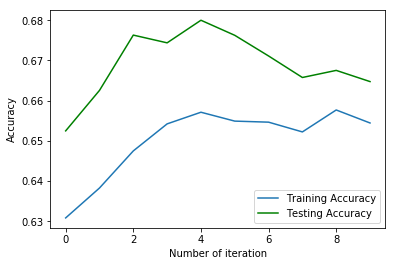

In [92]:
def plot_learning_curves(a,b):
    plt.figure()
    plt.plot(a)
    plt.plot(b, 'g')
    plt.legend(['Training Accuracy', 'Testing Accuracy'])
    plt.xlabel("Number of iteration")
    plt.ylabel("Accuracy")
    
plot_learning_curves(LSTM_results[0],LSTM_results[1])

In [93]:
p = []
r = []
for i in range(y_Bid_Retreat_test.shape[1]):
    if y_Bid_Retreat_test[0][i] < 0.5:
        r.append(0)
    else:
        r.append(1)
        
    if LSTM_results[3][0][i] < 0.5:
        p.append(0)
    else:
        p.append(1)
    
from sklearn.metrics import classification_report
print(classification_report(r, p))
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(r, p)
print('AUC: ', metrics.auc(fpr, tpr))

             precision    recall  f1-score   support

          0       0.87      0.68      0.76     14922
          1       0.32      0.60      0.42      3747

avg / total       0.76      0.66      0.70     18669

AUC:  0.6408769959272604


In [59]:
auc = [0.5551469455956133, 0.6009802883185787, 0.6184441991335998, 0.6486494382478238, 0.61692023, 0.6076367862819944]
test_a = [0.8040602, 0.77620655, 0.72424877, 0.66773796, 0.58149874, 0.48443943]

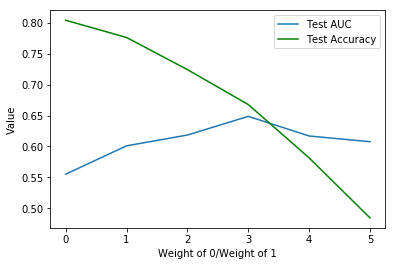

In [61]:
def plot_learning_curves2(a,b):
    plt.figure()
    plt.plot(a)
    plt.plot(b, 'g')
    plt.legend(['Test AUC', 'Test Accuracy'])
    plt.xlabel("Weight of 0/Weight of 1")
    plt.ylabel("Value")
    
plot_learning_curves2(auc, test_a )

### 用于预测 Ask Retreat

In [154]:
def RNN_model2(cell_type, units, max_len):   
    
    tf.reset_default_graph()  # reset the tensorflow graph
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    test_auc = []
    experiments_result = []
    num_epochs = 15 #定义迭代次数
    learning_rate = 0.001 
    batch_size = 100   
    fully_connected_hidden_units_1 = 32
    fully_connected_hidden_units_2 = 10
    max_time = max_len   
    classes = 1  
    initializer = tf.random_normal_initializer(mean=0.0, stddev = 1) #tf.random_normal_initializer() 
    unit_number = units[-1]   

    
    x, y_ = get_placeholders()
    l = tf.shape(x)[1]
    x_norm = tf.contrib.layers.batch_norm(x)

    if cell_type == 'LSTM':
        rnn_layers = [tf.contrib.rnn.LSTMCell(unit) for unit in units]
  
    if cell_type == 'GRU': 
        rnn_layers = [tf.contrib.rnn.GRUCell(unit) for unit in units]
    
  
    multicell = tf.contrib.rnn.MultiRNNCell(rnn_layers) 
    
    outputs, _ = tf.nn.dynamic_rnn(multicell, x_norm, dtype=tf.float32) 
    rnn_outputs = tf.reshape(outputs, [-1, unit_number]) #(bs * max_time, unit_number)
  
    A0 = rnn_outputs 
  
  
    W1 = tf.Variable(initializer([unit_number, fully_connected_hidden_units_1]), dtype = tf.float32) 
    b1 = tf.Variable(initializer([fully_connected_hidden_units_1]), dtype = tf.float32)  
    A1 = tf.nn.relu(tf.matmul(A0, W1) + b1)
    A1 = tf.contrib.layers.batch_norm(A1)

    W2 = tf.Variable(initializer([fully_connected_hidden_units_1, fully_connected_hidden_units_2]), dtype = tf.float32)  
    b2 = tf.Variable(initializer([fully_connected_hidden_units_2]), dtype = tf.float32) 
    A2 = tf.nn.relu(tf.matmul(A1, W2) + b2)
    A2 = tf.contrib.layers.batch_norm(A2)
    
    W3 = tf.Variable(initializer([fully_connected_hidden_units_2, classes]), dtype = tf.float32)  
    b3 = tf.Variable(initializer([classes]), dtype = tf.float32) 
    A3 = tf.matmul(A2, W3) + b3
    A3 = tf.contrib.layers.batch_norm(A3)
    
    y = tf.reshape(A3, [-1, l])  # A2:(bs, max_time)
    

    loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits = y, targets = y_, pos_weight = 4))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_, logits = y ) )
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    prediction = tf.sigmoid(y)
    prediction_class = tf.cast(prediction > 0.5, y.dtype)
    correct_prediction = tf.equal(prediction_class, y_)
    AUC = tf.metrics.auc(labels = y_, predictions = prediction_class)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    
    
    #####################################################

    # Train
    saver = tf.train.Saver()
    #init = tf.global_variables_initializer()
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    with tf.Session() as sess: #with tf.train.MonitoredSession() as sess:
        sess.run(init)
        epochs_completed = 0
        
        while epochs_completed < num_epochs:
            
            for i in range(int(X_train.shape[0] // batch_size)):
            
                x_train_betch = X_train[i * batch_size : (i + 1) * batch_size].reshape(-1, max_len, 18)
                y_train_betch = y_Ask_Retreat_train[i * batch_size : (i + 1) * batch_size].reshape(-1, max_len)

                #################
                # Training step #
                sess.run(train_step, feed_dict={x: x_train_betch, y_: y_train_betch})
                #################

            
            saver.save(sess, './Models/MyModel')
            epochs_completed = epochs_completed + 1
            print('***************** epochs_completed ********************: ', epochs_completed)
            
            
            current_acuracy = sess.run(accuracy, feed_dict={x: X_train, y_: y_Ask_Retreat_train})
            train_accuracy.append(current_acuracy)
            print("training accuracy:", current_acuracy)
            
            
            AUC_, _= sess.run(AUC, feed_dict={x: X_test, y_: y_Ask_Retreat_test})
            test_auc.append(AUC_)
            print("Test AUC:", AUC_)
                         
            current_acuracy2 = sess.run(accuracy, feed_dict={x: X_test, y_: y_Ask_Retreat_test})
            test_accuracy.append(current_acuracy2)
            print("testing accuracy:", current_acuracy2)
            
            
        
        predictions = sess.run(prediction, feed_dict={x: X_test, y_: y_Ask_Retreat_test})
        experiments_result.append(train_accuracy)
        experiments_result.append(test_accuracy)
        experiments_result.append(test_auc)
        experiments_result.append(predictions)
  
    return experiments_result

In [155]:
LSTM_results2 = RNN_model2('LSTM', [100,50], n_step)

***************** epochs_completed ********************:  1
training accuracy: 0.5962151
Test AUC: 0.0
testing accuracy: 0.591194
***************** epochs_completed ********************:  2
training accuracy: 0.60370845
Test AUC: 0.60734755
testing accuracy: 0.5961755
***************** epochs_completed ********************:  3
training accuracy: 0.63943547
Test AUC: 0.6037852
testing accuracy: 0.6315282
***************** epochs_completed ********************:  4
training accuracy: 0.6477252
Test AUC: 0.6072614
testing accuracy: 0.64663345
***************** epochs_completed ********************:  5
training accuracy: 0.6578374
Test AUC: 0.6122545
testing accuracy: 0.6561144
***************** epochs_completed ********************:  6
training accuracy: 0.66192174
Test AUC: 0.6132467
testing accuracy: 0.66184586
***************** epochs_completed ********************:  7
training accuracy: 0.670511
Test AUC: 0.61759484
testing accuracy: 0.66838074
***************** epochs_completed ******

In [156]:
p = []
r = []
for i in range(y_Ask_Retreat_test.shape[1]):
    if y_Ask_Retreat_test[0][i] < 0.5:
        r.append(0)
    else:
        r.append(1)
        
    if LSTM_results2[3][0][i] < 0.5:
        p.append(0)
    else:
        p.append(1)
    
from sklearn.metrics import classification_report
print(classification_report(r, p))
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(r, p)
print('AUC: ', metrics.auc(fpr, tpr))

             precision    recall  f1-score   support

          0       0.86      0.68      0.76     14885
          1       0.31      0.58      0.41      3784

avg / total       0.75      0.66      0.69     18669

AUC:  0.626776321068999
